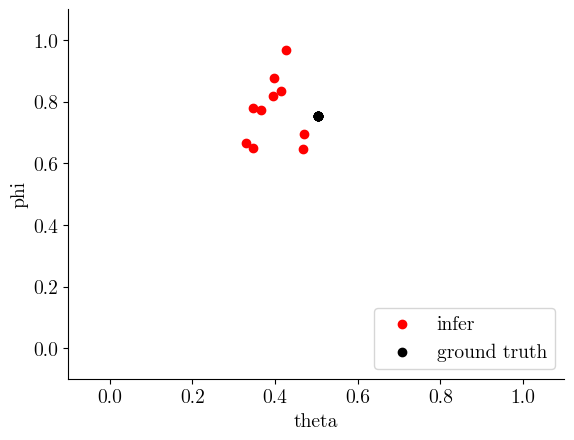

In [8]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from notification import notify
from env import cartpole
from stable_baselines3 import PPO
from pathlib import Path
from plot_ult import *
import pickle
from torch.nn.utils.rnn import pad_sequence

note = 'data'
agent_name = 'ppo_baseline_0331_5cost'
pt=torch.load('data/{}_{}.pt'.format(agent_name, note))


with open('data/{}_{}'.format(agent_name, note), 'rb') as f:
    x_data, ys = pickle.load(f)
y_data = [torch.tensor(y).view(-1) for y in ys]

# use a small subset for testing
# x_data, y_data = x_data[:100], y_data[:100]

y_data = torch.stack(y_data)
y_data=y_data[:,[3,9,11]]
y_data=y_data/(torch.max(y_data,axis=0)[0])



# Find the maximum length of your time series data
max_length = max([len(d) for d in x_data])

# Pad your time series data with zeros at the front
x_data = [torch.tensor(x) for x in x_data]
padded_data = pad_sequence(x_data, batch_first=True, padding_value=0)
padded_data.shape  # ntrial, ts, input feature



class GRUNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUNet, self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.gru=nn.GRU(input_size, hidden_size,
                          num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = out[:, -1, :]
        out = self.fc(out)
        return out, h



input_size = padded_data.shape[2]
num_layers = 2
hidden_size = 32
output_size=y_data[0].shape[0]
model = GRUNet(input_size=input_size, hidden_size=hidden_size,
               num_layers=num_layers, output_size=output_size)

model.load_state_dict(pt['model_state_dict'])
model.eval()

####################################
# a ground truth phi and theta--------------
env = cartpole.CartPoleEnv()
agent = PPO.load(Path('trained_agent')/agent_name)

phi=env.random_params()
theta=env.random_params()
# get trajectory-----------------------
for _ in range(10):

    # data of this phi x theta combination,
    # in format of (ts, obs+action), where obs first action last

    for _ in range(1):
        obs = env.reset(phi=phi, theta=theta)
        ep_obs = []
        ep_action = []
        while True:
            action, _states = agent.predict(obs)
            ep_action.append(action.item())
            ep_obs.append(obs)  # the obs before action
            obs, _reward, done, _info = env.step(action)
            if done:
                break
        ep_obs = torch.tensor(ep_obs)
        ep_action = torch.tensor(ep_action)
        ep_action.shape
        ep_obs.shape
        this_data=(
            torch.hstack([ep_obs[:, :4].float(), ep_action.reshape(-1, 1)]))
        
        
    # inference as inverse----------------------
    with torch.no_grad():
        pred,_=model(this_data.view(1,-1,5), None)  

    # plt.scatter(pred[0,0], phi[3]/10, label='phi len', color='r')
    # plt.scatter(pred[0,1], theta[3]/10, label='theta len',color='g')
    # plt.scatter(pred[0,2], theta[5], label='theta cost',color='b')
    # plt.plot([0,1],[0,1],'k')
    # plt.axis('equal')
    # quickleg(plt.gca(), bbox_to_anchor=(1,0))
    # quickspine(plt.gca())
    # plt.xlabel('true')
    # plt.ylabel('pred')


    plt.scatter(pred[0,1], pred[0,0], label='infer', color='r')
    plt.scatter(theta[3]/10, phi[3]/10, label='ground truth', color='k')    
    # plt.axis('equal')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    quickleg(plt.gca(), bbox_to_anchor=(1,0))
    quickspine(plt.gca())
    plt.xlabel('theta')
    plt.ylabel('phi')




